# Sloane Lab XML Parser

This notebook parses the TEI XML files from the Enlightenment Architectures project, extracts the data that we want to import into the Sloane Lab knowledge base, and checks if there are any errors or inconsistencies.

#### Import libraries

In [1]:
# -*- coding: future_fstrings -*-
import os
import re
import sys
import urllib
import titlecase
import pandas as pd

import rdflib
from rdflib import Namespace, URIRef, BNode, Literal
from rdflib.namespace import RDF, RDFS, OWL, XSD

from viapy import api
from bs4 import BeautifulSoup as Soup
from mapboxgl.utils import *
from mapboxgl.viz import *

from matplotlib import *
import matplotlib.pyplot as plt
%matplotlib inline

#### XML File path

In [2]:
# XML file path
XML_PATH = 'data/fossils_i.xml'

#### Function to handle catalogue numbers

In [3]:
# Function to transform the catalogue number to an integer
def cat_to_int(catnum):
    catnum = re.search('\d+', catnum)
    if catnum:
        return int(catnum.group(0))
    return None

#### Load all catalogues and their entries

In [4]:
# Open the XML file
with open(XML_PATH) as xml_file:

    # Read the file
    xml = xml_file.read()
    
    # Parse the file
    parsed_xml = Soup(xml, 'lxml')
    
    # Create empty list of people
    people_list = []
    
    # Create empty list of places
    place_list = []
    
    # For each person in the XML list...
    for person in parsed_xml.find('listperson').find_all('person'):

        # Create dictionary with person's internal ID
        person_dict = {'id': person['xml:id']}
        
        # Find the person's external IDs
        person_ids = person.find_all('idno')
        
        # For each external ID...
        for person_id in person_ids:

            # If the type of ID is VIAF...
            if person_id['type'] == 'viaf':
                
                # Add VIAF ID to person dictionary
                person_dict['viaf'] = person_id.text 
 
            # Otherwise, print person
            else:
                print(person)
 
        person_dict['names'] = [x.text for x in person.find_all('persname')]

        # Add the dictionary to the list
        people_list.append(person_dict)
    
    # For each place in the XML list...
    for place in parsed_xml.find('listplace').find_all('place'):
        
        # Create dictionary with place's internal ID
        place_dict = {'id': place['xml:id']}

        # Find the person's external IDs
        place_ids = place.find_all('idno')
        
        # For each external ID...
        for place_id in place_ids:
            
            # If the type of ID is VIAF...
            if place_id['type'] == 'viaf':
            
                # Add VIAF ID to place dictionary
                place_dict['viaf'] = place_id.text

            # If the type of ID is GEO...
            elif place_id['type'] == 'geo':
                
                try:
                    # Extract latitude and longitude
                    lat, lon = place_id.text.split(',')
                
                    # Add latitude to place dictionary
                    place_dict['lat'] = float(lat.strip())
                
                    # Add longitude to place dictionary
                    place_dict['lon'] = float(lon.strip())
                except:
                    print(place)
                
            # Otherwise, print place
            else:
                print(place)
        
        place_dict['names'] = [x.text for x in place.find_all('placename')]
            
        # Add the dictionary to the list
        place_list.append(place_dict)

# Open the JSON file
#with open("out/people.json", "w") as people_file:
#    json.dump(people_list, people_file)

# Open the JSON file
#with open("out/places.json", "w") as places_file:
#    json.dump(place_list, places_file)

<place xml:id="Eichstadt">
<placename>Eichstadt</placename>
<idno type="viaf">124967002</idno>
<idno type="geo"> 124967002</idno>
</place>
<place xml:id="Hispaniola">
<placename>Hispaniola</placename>
<placename>wreck on the coast of Espanola</placename>
<idno type="viaf">242111207</idno>
<idno type="geo"> failed</idno>
</place>
<place xml:id="Katzenelnbogen">
<placename>Country of Catzellenbogen &amp; belonging to the Landgrave of Hesse
                     cassell, northward of Mayence</placename>
<idno type="viaf">129154192 </idno>
<idno type="geo"> 50.26745,†7.97322</idno>
</place>
<place xml:id="Manila">
<placename>Maniglia in the East Indies </placename>
<idno type="viaf">128902416</idno>
<idno type="geo"> 14.6042,†120.9822</idno>
</place>
<place xml:id="Melo_Island">
<placename>Melo Island</placename>
<idno type="geo"> 11.03333,†-15.21667</idno>
</place>
<place xml:id="New_England">
<placename>New England</placename>
<idno type="geo"> 44,†-71</idno>
</place>
<place xml:id="Oundl

In [5]:
# List of catalogues
cats = []

# Open the XML file
with open(XML_PATH) as xml_file:

    # Find all catalogues in the manuscript
    catalogues = parsed_xml.find_all('div2')
    
    print(len(catalogues))
    
    prevDict = {}
    
    pageNum = "NHM-UK_L_433034_001a"
    prevPageNum = None
    prevParent = None
    force = False
    
    # For each catalogue...
    for i, catalogue in enumerate(catalogues):
        
        if (i in [1,3,7]):
            cat_dict = prevDict
        else:
            # Create catalogue dictionary
            cat_dict = {}
            
            # Create list of entries
            cat_dict['entries'] = []
                
        # Find all entries in the catalogue
        entries = catalogue.find_all('div3')
    
        # For each entry...
        for index, entry in enumerate(entries):
            
            # Get number of entry
            catnum = entry.find('ea:catnum').get_text() if entry.find('ea:catnum') else None
            
            # Get people
            people = entry.find_all('persname')
            
            # Get places
            places = entry.find_all('placename')
                        
            prev = entry.find_previous_sibling('pb')
            
            if pageNum and prev and not force:
                pg = prev['xml:id']
                if int(pg.split('_')[-1].strip('a').strip('v')) >= int(pageNum.split('_')[-1].strip('a').strip('v')):
                    pageNum = pg
            
            prev = entry.find_previous_sibling()
            
            if prev and prev.name == 'pb':
                pageNum = prev['xml:id']
            
            if pageNum and entry.parent != prevParent and not force:
                pg = entry.parent.find_previous_sibling('pb')['xml:id']
                if int(pg.split('_')[-1].strip('a').strip('v')) >= int(pageNum.split('_')[-1].strip('a').strip('v')):
                    pageNum = pg
            
            prevParent = entry.parent

            if force:
                force = False
                        
            # Create entry dictionary
            entry_dict = {
                'index': index + 1,
                'num_str': ' '.join(catnum.split()) if catnum else None,
                'num_int': cat_to_int(catnum) if catnum else None,
                'page': pageNum,
                'text': ' '.join(entry.text.split()),
                'xml': str(entry),
                'people': [{'id': x['ref'].strip('#') if 'ref' in x.attrs else None, 'name': ' '.join(x.text.split())} for x in people] if people else None,
                'places': [{'id': x['ref'].strip('#') if 'ref' in x.attrs else None, 'name': ' '.join(x.text.split())} for x in places] if places else None
            }

            if pageNum != prevPageNum:
                print(f"{pageNum}: {' '.join(catnum.split()) if catnum else ''}")
            
            prevPageNum = pageNum

            pb = entry.find('pb')
            
            if pb:
                print('FORCE')
                pageNum = pb['xml:id']
                force = True
                    
            # Append entry to entry list
            cat_dict['entries'].append(entry_dict)
        
        if (i in [1,3,4,5,7,8]):
            # Get catalogue title
            cat_dict['title'] = catalogue.find('label').text
            
            # Append catalogue to catalogue list
            cats.append(cat_dict)
        else:
            prevDict = cat_dict

9
NHM-UK_L_433034_001a: -1179.
NHM-UK_L_433034_002: 1.
NHM-UK_L_433034_002a: 1202.
NHM-UK_L_433034_003: 14.
NHM-UK_L_433034_003a: 1221.
NHM-UK_L_433034_004: 33.
NHM-UK_L_433034_004a: -1245.
NHM-UK_L_433034_005: 54.
NHM-UK_L_433034_005a: -1271.
NHM-UK_L_433034_006: 69.
NHM-UK_L_433034_006a: -1298.
NHM-UK_L_433034_007: 80.
NHM-UK_L_433034_007a: -1321.
NHM-UK_L_433034_008: 96.
NHM-UK_L_433034_008a: -1348.
FORCE
NHM-UK_L_433034_009: 112.
NHM-UK_L_433034_009a: 1368.
NHM-UK_L_433034_010: -126.
NHM-UK_L_433034_010a: 1379.
NHM-UK_L_433034_011: 140.
NHM-UK_L_433034_011a: 
NHM-UK_L_433034_012: 152.
NHM-UK_L_433034_012a: 1386.
NHM-UK_L_433034_013: 165.
NHM-UK_L_433034_013a: 1393.
NHM-UK_L_433034_014: 177.
NHM-UK_L_433034_014a: 1406.
NHM-UK_L_433034_015: 191.
NHM-UK_L_433034_015a: 207.
NHM-UK_L_433034_016: 203.
NHM-UK_L_433034_016a: 1417.
NHM-UK_L_433034_017: 215.
NHM-UK_L_433034_017a: 
NHM-UK_L_433034_018: 229.
NHM-UK_L_433034_018a: 
NHM-UK_L_433034_019: 240.
NHM-UK_L_433034_019a: 
NHM-UK_L_43303

FORCE
NHM-UK_L_433034_210: -482.
FORCE
NHM-UK_L_433034_211: -495.
FORCE
NHM-UK_L_433034_211a: 528
FORCE
NHM-UK_L_433034_212: -512.
FORCE
NHM-UK_L_433034_213: -530.
FORCE
NHM-UK_L_433034_214: -550.
FORCE
NHM-UK_L_433034_215: -574.
FORCE
NHM-UK_L_433034_216: -602.
FORCE
NHM-UK_L_433034_216a: 
FORCE
NHM-UK_L_433034_217: -627.
FORCE
NHM-UK_L_433034_218: -647.
FORCE
NHM-UK_L_433034_219: 658.
FORCE
NHM-UK_L_433034_226: 
FORCE
NHM-UK_L_433034_227: 1.
FORCE
NHM-UK_L_433034_228: 18.
FORCE
NHM-UK_L_433034_229: 30.
FORCE
NHM-UK_L_433034_230: 44.
FORCE
NHM-UK_L_433034_231: 55.
FORCE
NHM-UK_L_433034_232: 65.
FORCE
NHM-UK_L_433034_233: 75.
FORCE
NHM-UK_L_433034_234: 84.
FORCE
NHM-UK_L_433034_235: 94.
FORCE
NHM-UK_L_433034_235a: 112
FORCE
NHM-UK_L_433034_236: 105.
FORCE
NHM-UK_L_433034_237: 113.
FORCE
NHM-UK_L_433034_238: 124.
FORCE
NHM-UK_L_433034_239: 135.
FORCE
NHM-UK_L_433034_240: -146.
FORCE
NHM-UK_L_433034_241: -155.
FORCE
NHM-UK_L_433034_242: -163.
FORCE
NHM-UK_L_433034_243: -171.
FORCE
NHM-UK

#### How many people in the list?

In [6]:
len(people_list)

2707

#### How many places in the list?

In [7]:
len(place_list)

553

#### How many catalogues?

In [8]:
# Print number of catalogues
len(cats)

6

#### What are their titles?

In [9]:
# Print all catalogue titles
[x['title'].strip() for x in cats]

['Coralls.',
 'Serpents &c.',
 'Echini',
 'Crustacea.',
 'Starr fishes.',
 'Humana.']

#### What are their lengths?

In [10]:
# Compute catalogue lengths
for x in cats:
    x['length'] = len(x['entries'])

[x['length'] for x in cats]

[1515, 567, 671, 370, 180, 759]

#### Transform the list of catalogues into a dataframe

In [11]:
cat_df = pd.DataFrame(cats)
cat_df

,entries,title,length
0,"[{'index': 1, 'num_str': '-1179.', 'num_int': ...",Coralls.,1515
1,"[{'index': 1, 'num_str': '-455.', 'num_int': 4...",Serpents &c.,567
2,"[{'index': 1, 'num_str': '-11.', 'num_int': 11...",Echini,671
3,"[{'index': 1, 'num_str': None, 'num_int': None...",Crustacea.,370
4,"[{'index': 1, 'num_str': '14.', 'num_int': 14,...",Starr fishes.,180
5,"[{'index': 1, 'num_str': '1.', 'num_int': 1, '...",Humana.,759


#### Display the lengths of the catalogues

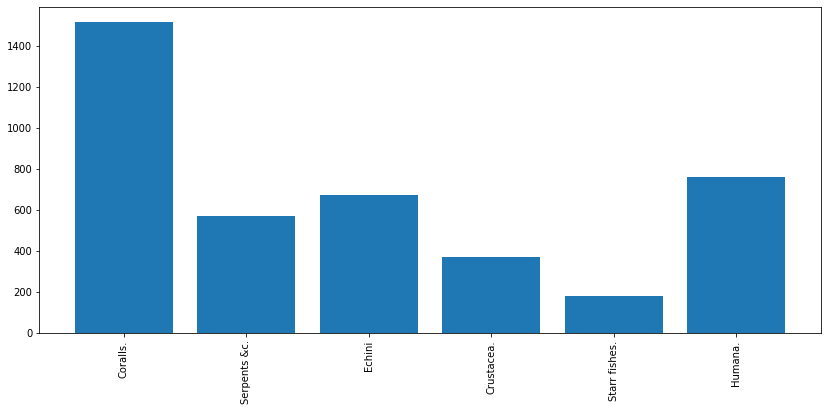

In [12]:
plt.figure(figsize=(14,6))
plt.xticks(range(30), rotation='vertical')
plt.bar(cat_df['title'],cat_df['length'])
plt.show()

#### First catalogue: Coralls

In [13]:
# Check first catalogue
cats[0]

{'entries': [{'index': 1,
   'num_str': '-1179.',
   'num_int': 1179,
   'page': 'NHM-UK_L_433034_001a',
   'text': '-1179. Sponge from the beach at fishers Island. There is stone of it thrown up by the sea. from Mr . Winthorpe . from New England. 202',
   'xml': '<div3>\n<ea:catnum place="margin" type="primary"> -1179.</ea:catnum>\n<p>Sponge from the beach at <placename ref="#Fisher_Island">fishers\n                        Island</placename>. There is stone of it<lb></lb> thrown up by the\n                        <geogfeat>sea</geogfeat>. from <persname>\n<abbr>M<hi rend="sup">r</hi>\n</abbr>. <surname>Winthorpe</surname> .</persname> from<lb></lb>\n<placename ref="#New_England">New England</placename>.</p>\n<p><add rend="pencil">202</add></p>\n</div3>',
   'people': [{'id': None, 'name': 'Mr . Winthorpe .'}],
   'places': [{'id': 'Fisher_Island', 'name': 'fishers Island'},
    {'id': 'New_England', 'name': 'New England'}]},
  {'index': 2,
   'num_str': '-1180.',
   'num_int': 1180,
 

#### What is the first catalogue?

In [14]:
# Print title of first catalogue
cats[0]['title']

'Coralls.'

#### How many catalogue entries in Miscellanies?

In [15]:
# Print number of entries in first catalogue
len(cats[0]['entries'])

1515

#### What is the first entry?

In [16]:
# Print first entry
cats[0]['entries'][0]

{'index': 1,
 'num_str': '-1179.',
 'num_int': 1179,
 'page': 'NHM-UK_L_433034_001a',
 'text': '-1179. Sponge from the beach at fishers Island. There is stone of it thrown up by the sea. from Mr . Winthorpe . from New England. 202',
 'xml': '<div3>\n<ea:catnum place="margin" type="primary"> -1179.</ea:catnum>\n<p>Sponge from the beach at <placename ref="#Fisher_Island">fishers\n                        Island</placename>. There is stone of it<lb></lb> thrown up by the\n                        <geogfeat>sea</geogfeat>. from <persname>\n<abbr>M<hi rend="sup">r</hi>\n</abbr>. <surname>Winthorpe</surname> .</persname> from<lb></lb>\n<placename ref="#New_England">New England</placename>.</p>\n<p><add rend="pencil">202</add></p>\n</div3>',
 'people': [{'id': None, 'name': 'Mr . Winthorpe .'}],
 'places': [{'id': 'Fisher_Island', 'name': 'fishers Island'},
  {'id': 'New_England', 'name': 'New England'}]}

#### Put all the data in a dataframe

In [17]:
# List of dataframes
dataframes = []

# For each catalogue (excluding indexes)...
for cat in [x for i, x in enumerate(cats) if i not in (3, 6)]:

    # Create dataframe from each catalogue
    df = pd.DataFrame(cat['entries'])

    # Set visualisation options
    pd.options.display.precision = 0

    # Print the dataframe
    df

    # Drop nulls
    df = df.dropna(subset=['num_int'])

    # Sort by entry number
    df = df.sort_values(by=['num_int'])
    
    # Append dataframe to list
    dataframes.append(df)

# Print the first dataframe
dataframes[0]

,index,num_str,num_int,page,text,xml,people,places
23,1,1.,1,NHM-UK_L_433034_002,1. Corallium album porosum maximum muricatum. ...,"<div3>\n<ea:catnum place=""margin"" type=""primar...",None,None
24,2,2.,2,NHM-UK_L_433034_002,2. Frutex marinus? Rete marin. branched? LXXVI,"<div3>\n<ea:catnum place=""margin"" type=""primar...",None,None
25,3,3.,3,NHM-UK_L_433034_002,3. Corallium porosum album maxi= =mum striatum...,"<div3>\n<ea:catnum place=""margin"" type=""primar...",None,"[{'id': 'Canaries', 'name': 'Canaries'}]"
26,4,4.,4,NHM-UK_L_433034_002,4. Corallina fruticosa elatior ramis quaquaver...,"<div3>\n<ea:catnum place=""margin"" type=""primar...",None,None
27,5,5.,5,NHM-UK_L_433034_002,5. The same with No. 3. with barnacles upon it...,"<div3>\n<ea:catnum place=""margin"" type=""primar...",None,None
...,...,...,...,...,...,...,...,...
458,436,1417.,1417,NHM-UK_L_433034_016a,16a 1417. Lapis astroites growing on the top o...,"<div3>\n<p>\n<add hand=""later"" rend=""pencil"" s...","[{'id': None, 'name': 'Revd. Mr. Clark'}]","[{'id': 'Barbados', 'name': 'Barbadoes'}]"
459,437,1418,1418,NHM-UK_L_433034_016a,1418 A piece of fossil Madrepora? Id. 207 15 P.,"<div3>\n<ea:catnum place=""margin"" type=""primar...",None,None
460,438,1419.,1419,NHM-UK_L_433034_016a,1419. A masse of purple & white Worm Shells up...,"<div3>\n<ea:catnum place=""margin"" type=""primar...",None,None
461,439,1420,1420,NHM-UK_L_433034_016a,1420 A congeries of smaller Worms wt. a Balanu...,"<div3>\n<ea:catnum place=""margin"" type=""primar...",None,None


#### Declare prefixes and create graph

In [18]:
# Create namespaces
slb=Namespace("http://sloanelab.org/");
ecrm=Namespace("http://erlangen-crm.org/current/");
crmdig=Namespace("http://www.ics.forth.gr/isl/CRMdig/");

# Create graph
graph = rdflib.Graph()

# Bind prefixes
graph.bind("slb", slb)
graph.bind("ecrm", ecrm)
graph.bind("crmdig", crmdig)

#### Add catalogues

In [19]:
# Manuscript
msIRI = slb[f'E22/fossils_i'];
graph.add((msIRI, RDF.type, ecrm['E22_Human-Made_Object']))
graph.add((msIRI, ecrm.P2_has_type, slb['E22/manuscript']))
graph.add((msIRI, RDFS.label, Literal('Fossils I')))

# XML
xmlIRI = slb[f'D1/fossils_i'];
graph.add((xmlIRI, RDF.type, crmdig.D1_Digital_Object))
graph.add((xmlIRI, ecrm.P2_has_type, slb['E55/historical_dataset']))
graph.add((xmlIRI, RDFS.label, Literal('Fossils I')))

# Link XML to manuscript
graph.add((xmlIRI, slb['P130.10_contains_elements_of'], msIRI))

# Catalogues
cat1IRI = slb[f'E73/coralls'];
graph.add((cat1IRI, RDF.type, ecrm.E73_Information_Object))
graph.add((cat1IRI, ecrm.P2_has_type, slb['E55/historical_catalogue']))
graph.add((cat1IRI, RDFS.label, Literal('Coralls')))

cat2IRI = slb[f'E73/serpents'];
graph.add((cat2IRI, RDF.type, ecrm.E73_Information_Object))
graph.add((cat2IRI, ecrm.P2_has_type, slb['E55/historical_catalogue']))
graph.add((cat2IRI, RDFS.label, Literal('Serpents')))

cat3IRI = slb[f'E73/echini'];
graph.add((cat3IRI, RDF.type, ecrm.E73_Information_Object))
graph.add((cat3IRI, ecrm.P2_has_type, slb['E55/historical_catalogue']))
graph.add((cat3IRI, RDFS.label, Literal('Echini')))

cat4IRI = slb[f'E73/crustacea'];
graph.add((cat4IRI, RDF.type, ecrm.E73_Information_Object))
graph.add((cat4IRI, ecrm.P2_has_type, slb['E55/historical_catalogue']))
graph.add((cat4IRI, RDFS.label, Literal('Crustacea')))

cat5IRI = slb[f'E73/starr_fishes'];
graph.add((cat5IRI, RDF.type, ecrm.E73_Information_Object))
graph.add((cat5IRI, ecrm.P2_has_type, slb['E55/historical_catalogue']))
graph.add((cat5IRI, RDFS.label, Literal('Starr Fishes')))

cat6IRI = slb[f'E73/humana'];
graph.add((cat6IRI, RDF.type, ecrm.E73_Information_Object))
graph.add((cat6IRI, ecrm.P2_has_type, slb['E55/historical_catalogue']))
graph.add((cat6IRI, RDFS.label, Literal('Humana')))

graph.add((xmlIRI, ecrm.P148_has_component, cat1IRI))
graph.add((xmlIRI, ecrm.P148_has_component, cat2IRI))
graph.add((xmlIRI, ecrm.P148_has_component, cat3IRI))
graph.add((xmlIRI, ecrm.P148_has_component, cat4IRI))
graph.add((xmlIRI, ecrm.P148_has_component, cat5IRI))
graph.add((xmlIRI, ecrm.P148_has_component, cat6IRI))

<Graph identifier=Nb3361125b91541ee86dcd4b92cbca446 (<class 'rdflib.graph.Graph'>)>

In [20]:
catNames = ['coralls', 'serpents', 'echini', 'crustacea', 'starr_fishes', 'humana']

# For each dataframe...
for i, df in enumerate(dataframes):

  # For each row in the dataframe...
  for index, row in df.iterrows():
    
    # Get entry number
    entryNumStr = row["num_str"]
    entryNumInt = int(row["num_int"])
    
    # Get entry text
    entryText = row["text"]
    
    # Get people and places
    people = row["people"] or []
    places = row["places"] or []
    
    # Create entry IRI
    entryIRI = slb[f'E73/{catNames[i]}/{entryNumInt}'];
    
    # Create page IRI
    # pageIRI = slb[f'E19/miscellanies/{pageID}'];

    catTitle = titlecase.titlecase(catNames[i].replace('_',' '))
    
    # Add entry to graph
    graph.add((entryIRI, RDF.type, ecrm.E73_Information_Object))
    graph.add((entryIRI, RDFS.label, Literal(f'{catTitle} Entry {entryNumInt}')))
    graph.add((entryIRI, ecrm.P2_has_type, slb['E55/catalogue_entry']))
    
    # Add entry text to graph
    graph.add((entryIRI, ecrm.P190_has_symbolic_content, Literal(entryText)))
    
    # Add entry number to graph
    graph.add((entryIRI, ecrm.P1_is_identified_by, Literal(entryNumStr)))
    
    # Add page to graph
    # graph.add((pageIRI, RDF.type, ecrm.E19_Physical_Object))
   
    # Connect entry to page
    # graph.add((pageIRI, ecrm.P128_carries, entryIRI))
    
    # Connect entry to catalogue
    graph.add((slb[f'E73/{catNames[i]}'], ecrm.P148_has_component, entryIRI))
    
    # Create object IRI
    objIRI = slb[f'E19/{catNames[i]}/{entryNumInt}'];
    
    # Connect entry to object
    graph.add((objIRI, RDF.type, ecrm.E19_Physical_Object))
    graph.add((objIRI, RDFS.label, Literal(f'{catTitle} Object {entryNumInt}')))
    graph.add((entryIRI, ecrm.P129_is_about, objIRI))

    # For each person...
    for person in people:
        
        if not person["id"]:
            print(person)
        else:
            # Create person IRI
            personIRI = slb[f'E21/{person["id"].strip().replace(" ", "_")}'];
        
            # Connect person to entry
            graph.add((entryIRI, ecrm.P67_refers_to, personIRI))

    # For each place...
    for place in places:
        
        # Create place IRI
        try:
            placeIRI = slb[f'E53/{place["id"].strip().replace(" ", "_")}'];
        except AttributeError:
            print(place["id"])
                
        # Connect place to entry
        graph.add((entryIRI, ecrm.P67_refers_to, placeIRI))

{'id': None, 'name': 'Dr. Leigh'}
{'id': None, 'name': 'Capt. Bennet'}
{'id': None, 'name': 'Capt. Hickes'}
{'id': None, 'name': 'my selfe'}
None
{'id': None, 'name': 'Capt. Bennet'}
None
{'id': None, 'name': 'Dr. L.'}
None
{'id': None, 'name': 'Dr. Walraven'}
{'id': None, 'name': 'Mr. Pinfold.'}
{'id': None, 'name': 'Capt. Bennet'}
None
None
None
{'id': None, 'name': 'Indians'}
None
{'id': None, 'name': 'Mr. Cunningham'}
None
None
{'id': None, 'name': 'Mr. Theobalds. ye. younger.'}
{'id': None, 'name': 'Mr. Fowler.'}
{'id': None, 'name': 'Dr. Preston'}
{'id': None, 'name': 'Dr. Stuart'}
None
{'id': None, 'name': 'Dr. Hook?'}
{'id': None, 'name': 'Mr. Beaumont'}
{'id': None, 'name': 'Mr. Beaumont.'}
None
None
None
None
{'id': None, 'name': 'Mr. Paterson.'}
None
None
{'id': None, 'name': 'Dr. Hook'}
{'id': None, 'name': 'Dr. Oliver'}
None
None
{'id': None, 'name': 'Mr. Vernon'}
{'id': None, 'name': 'Dr. Lavater'}
{'id': None, 'name': 'Dr. Woodward?'}
{'id': None, 'name': 'Mr. Vernon'}
N

None
None
None
None
None
None
None
{'id': None, 'name': 'Mr. Jones'}
{'id': None, 'name': 'Mr. Jones'}
{'id': None, 'name': 'Dr. Stuart'}
{'id': None, 'name': 'Mr. Cunningham'}
None
{'id': None, 'name': 'Mr. Byrd & given me by Mr. Geekie'}
{'id': None, 'name': 'Dr. Dolnus'}
None
{'id': None, 'name': 'Dr. Browne'}
{'id': None, 'name': 'Dr. Brown'}
{'id': None, 'name': 'Dr. S. Brown'}
{'id': None, 'name': 'Dr. Brown'}
{'id': None, 'name': 'Sr. Tho. Brown'}
{'id': None, 'name': 'Dr. Browne'}
{'id': None, 'name': 'Sr. Tho. Brown'}
{'id': None, 'name': 'Mr. Pierce. Sr. Tho. Brown'}
None
{'id': None, 'name': 'Dr. S. Brown'}
{'id': None, 'name': 'Dr. Br.'}
{'id': None, 'name': 'Mr. Ayrie'}
{'id': None, 'name': 'Dr. Colas of Prussia'}
{'id': None, 'name': 'seaman'}
{'id': None, 'name': 'Mr. Lawson'}
None
None
None
{'id': None, 'name': 'Dr. Krieg'}
{'id': None, 'name': 'Dr. Brown?'}
{'id': None, 'name': 'Jezreel Jones'}
None
None
{'id': None, 'name': 'Mr. Burnet'}
{'id': None, 'name': 'Dr. Cypr

#### Add catalogue entries

In [21]:
name_query = """
PREFIX ecrm: <http://erlangen-crm.org/current/>

SELECT ?person ?label

WHERE {
    ?person rdf:type ecrm:E21_Person .
    ?person rdfs:label ?label .
}
"""

# Return a dataframe containing all names
names = pd.DataFrame(graph.query(name_query), columns=["person", "label"])
names[0:10]

,person,label


In [22]:
print(len(graph))

32454


In [23]:
graph.serialize(destination='/Users/danielemetilli/Downloads/sloane-graph-fossils-i.ttl', format="turtle");